In [182]:
# Multi-Layer Perceptron Regression

In [183]:
import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
import torch.nn.functional as F

import numpy as np

import matplotlib.pyplot as plt

from tqdm import trange, tqdm

In [184]:
# Create a SineDataset class by importin Pytorch Dataset class
class SineDataset(Dataset):
    """
    Data noisy sinewave dataset
    """
    def __init__(self, num_datapoints):
        # Lets generate the noisy sinewave points

        # Create 'num_points' worth of random x points using uniform distribution (0, 1) using torch.rand
        # Then scale and shift points to be between -9 and 9
        self.x_data = torch.rand(num_datapoints, 1) * 2 * 9 - 9

        # Calculate the sin of all datapoints 
        self.y_data = (torch.sin(self.x_data)) / 2.5

        # Add some gaussein noise to each datapoint using torch.randn_like
        # Note: torch.randn_like will generate a tensor of gaussein noise the same size
        # and type as the provided tensor
        self.y_data += torch.randn_like(self.y_data) / 20

    def __getitem__(self, index):
        # This function is called by the DataLoader calss whenever it wants a new mini-batch
        # The DataLoader class will pass the dataset and number of datapoint indexes (mini-batch of indexes)
        # It is up to the dataset's __getitem__ function to output the corresponding input datapoints
        return self.x_data[index], self.y_data[index]
    
        # Note:Pytorch will actually pass the __getitem__ function one index at a time
        # If you use multiple dataLOADER "workers" multiple __getitem__ calls will be made in parallel
        # (Pytorch will spawn multiple threads)

    def __len__(self):
        # We also need to specify a "length" function, Python will use this fuction whenever
        # You use the Python len(function)
        # We need to define it so the dataLOADER knows how big the dataSET is!
        return self.x_data.shape[0]



In [185]:
# Now that we've defined our dataset, let's create an instance of it for training and testing, and then create dataloaders to make ir easy to iterate
n_x_train = 30000   # the number of training datapoints
n_x_test = 8000     # the number of testing datapoints
batch_size = 256

# Create an instance of the SineDataset for both training and testing set
dataset_train = SineDataset(n_x_train)
dataset_test = SineDataset(n_x_test)

# Now we need to pass the dataset to the Pytorch dataloader class along with some other args
# batch_size -  the size of our mini batch
# shuffle - whether or not we want to shuffle the dataset
data_loader_train = DataLoader(dataset=dataset_train, batch_size=batch_size, shuffle=True)
data_loader_test = DataLoader(dataset=dataset_test, batch_size=batch_size, shuffle=False)

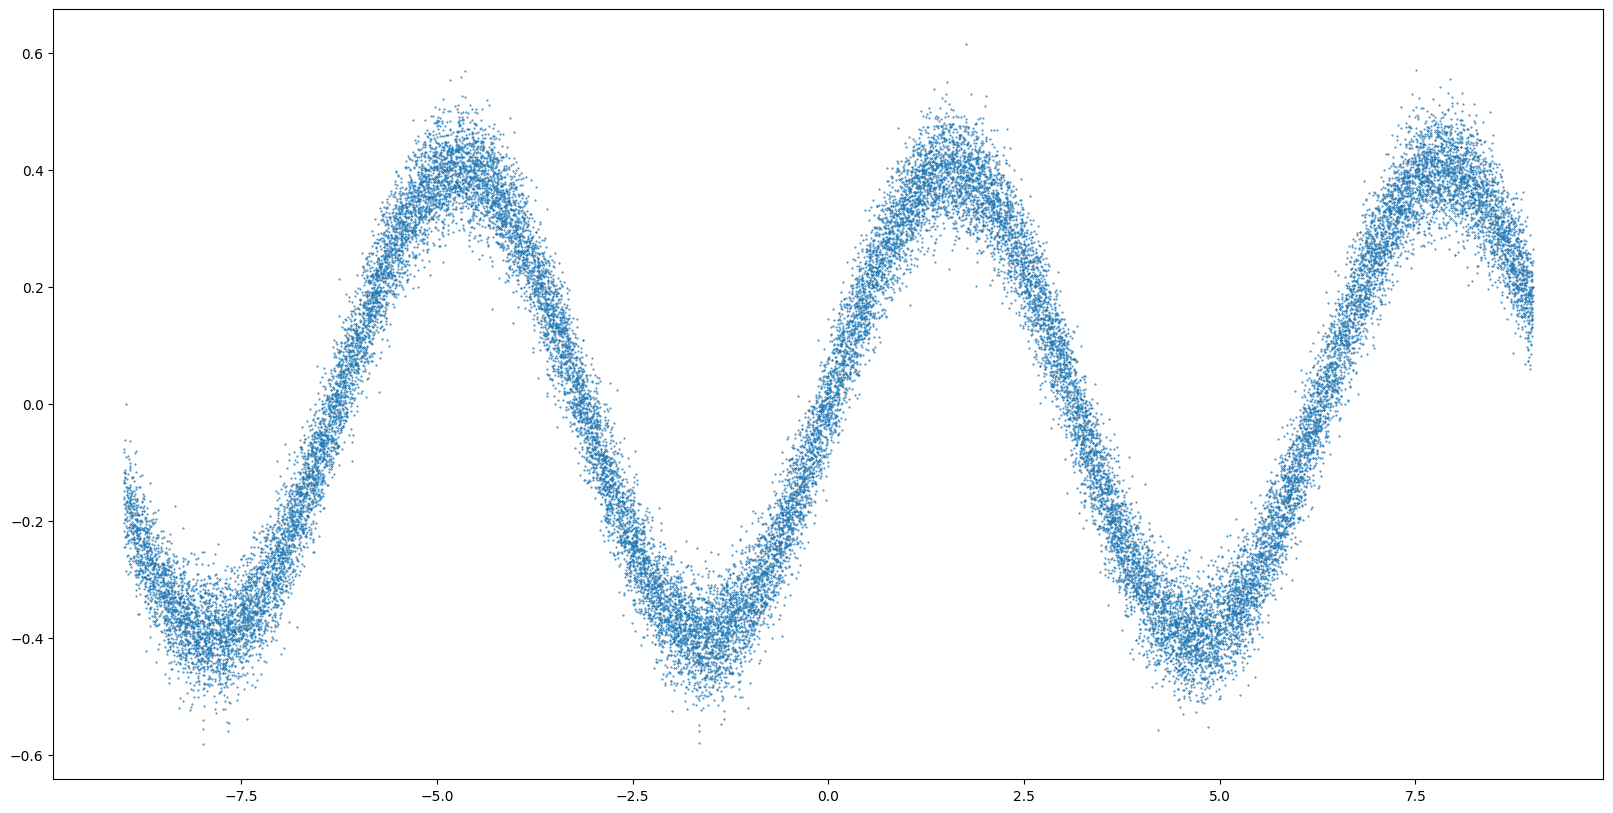

In [186]:
# Lets visualize the dataset we've created!
fig = plt.figure(figsize=(20, 10))
plt.scatter(dataset_train.x_data, dataset_train.y_data, s=0.2)

In [187]:
# Define our network class by using the nn.module
class ShallowLinear(nn.Module):
    '''
    A simple, general purpose, fully connected network
    '''
    # Here we initialise our network and define all the layers we need
    def __init__(self, input_size, output_size, hidden_size):
        # Perform initialization of the pytorch superclass, this will allow us to inherit 
        # functions from the nn.Module class
        super(ShallowLinear, self).__init__()
        # Define the linear layers we will need
        # Note: the output of one layer must be the same size 
        # as the input to the next!
        self.linear1 = nn.Linear(input_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.linear3 = nn.Linear(hidden_size, hidden_size)
        self.linear4 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # This function is an important one and we must create it or pytorch will give us an error!
        # This function defines the "forward pass" of our neural network
        # and will be called when we simply call our network class
        # aka we can do net(input) instead of net.forward(input)
        
        # Lets define the sqeuence of events for our forward pass!
        x = self.linear1(x) # hidden layer
        x = torch.tanh(x)   # activation function
        
        x = self.linear2(x) # hidden layer
        x = torch.tanh(x)   # activation function
        
        x = self.linear3(x) # hidden layer
        x = torch.tanh(x)   # activation function

        # No activation function on the output!!
        x = self.linear4(x) # output layer
        
        # Note we re-use the variable x as we don't care about overwriting it 
        # though in later labs we will want to use earlier hidden layers
        # later in our network!
        return x

In [188]:
# Define the hyperparameters
learning_rate = 5e-4
nepochs = 32

# Create model
shallow_model = ShallowLinear(input_size=1, output_size=1, hidden_size=64)

# Initialize the optimizer with above parameters
optimizer = optim.Adam(shallow_model.parameters(), lr=learning_rate)

# Define the loss function
loss_fn = nn.MSELoss()  # mean squared error

In [189]:
# Here we create two lists to store the loss values from training and testing
training_loss_logger = []
testing_loss_logger = []
# Note: create them outside of the train/test cell so they don't get overwritten 
# if we want to run the cell again

In [190]:
# The main train/test cell
# This will run one epoch of training and then one epoch of testing nepochs times

for epoch in trange(nepochs, desc="Epochs", leave=False):
    
    # Perform training Loop!
    for x, y in tqdm(data_loader_train, desc="Training", leave=False):

        # Run forward calculation
        y_predict = shallow_model(x)

        # Compute loss.
        loss = loss_fn(y_predict, y)

        # Before the backward pass, use the optimizer object to zero all of the
        # gradients for the variables it will update (which are the learnable weights
        # of the model)
        optimizer.zero_grad()

        # Backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()

        # Calling the step function on an Optimizer makes an update to its parameters
        optimizer.step()

        # Log the loss so we can visualise the training plot later
        training_loss_logger.append(loss.item())

    # Perform a test Loop!
    with torch.no_grad():
        test_loss_accum = 0
        for i, (x, y) in enumerate(tqdm(data_loader_test, desc="Testing", leave=False)):

            # Run forward calculation
            y_predict = shallow_model(x)
            # Compute loss.
            loss = loss_fn(y_predict, y)
            # Log the loss so we can visualise the training plot later
            testing_loss_logger.append(loss.item())
            test_loss_accum += loss
            
        test_loss_accum /= (i + 1)
        
print("Epoch [%d/%d], Average Test Loss %.4f" %(epoch, nepochs, test_loss_accum))

Epoch [9/10], Average Test Loss 0.0120


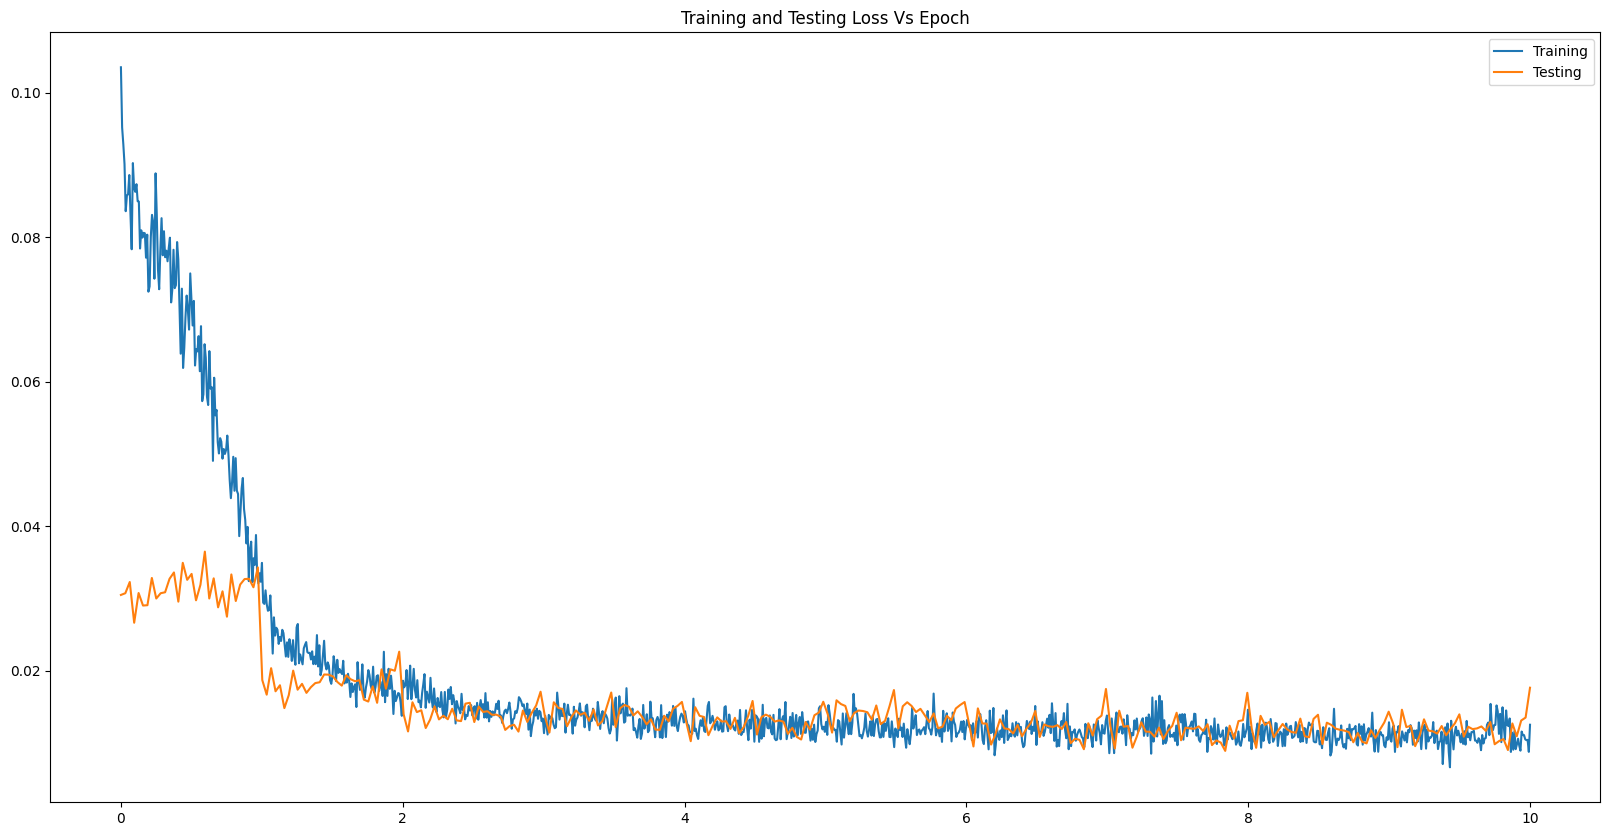

In [191]:
fig = plt.figure(figsize=(20, 10))
plt.plot(np.linspace(0, nepochs, len(training_loss_logger)), training_loss_logger)
plt.plot(np.linspace(0, nepochs, len(testing_loss_logger)), testing_loss_logger)
title = plt.title("Training and Testing Loss Vs Epoch")
legend = plt.legend(["Training", "Testing"])

In [192]:
test_outputs = []
# Perform a test Loop!
with torch.no_grad():
    for x, y in data_loader_test:
        # Run forward calculation
        y_predict = shallow_model(x)
        test_outputs.append(y_predict.detach().cpu().numpy())
        
test_outputs = np.concatenate(test_outputs)

Text(-9, 0.48, '- Sine wave (with noise)')

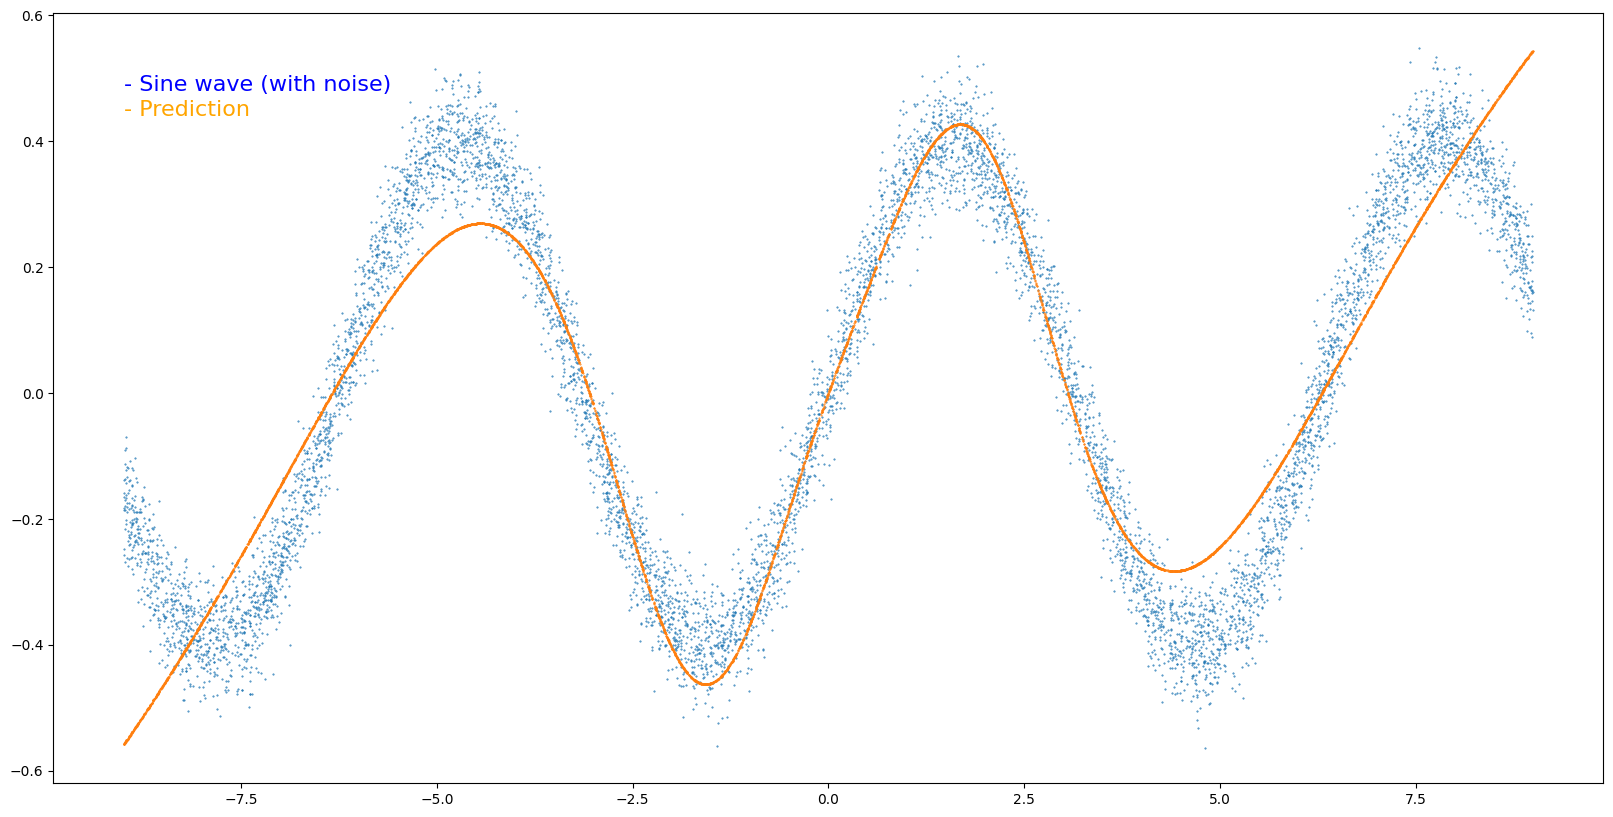

In [193]:
# Plot the testdata against the model's predicted outputs, how accurate is it?
fig = plt.figure(figsize=(20, 10))
plt.scatter(dataset_test.x_data, dataset_test.y_data, s=0.2)
plt.scatter(dataset_test.x_data, test_outputs, s=0.2)
plt.text(-9, 0.44, "- Prediction", color="orange", fontsize=16)
plt.text(-9, 0.48, "- Sine wave (with noise)", color="blue", fontsize=16)
